# RT Model

A vanilla RT model for scoring

## Load sample data

In [1]:
file_path = 'thermo_HeLa.ms_data.hdf'

In [2]:
import alphapept.io
from alphapept.score import get_ML_features, filter_with_ML, filter_with_x_tandem, cut_global_fdr, train_RF

ms_file = alphapept.io.MS_Data_File(file_path)

df_org = ms_file.read(dataset_name='peptide_fdr')

df = df_org.copy()

In [3]:
import numpy as np
import pandas as pd

In [4]:
df = df[~df['sequence'].str.endswith('_decoy')]
df = df[~df['sequence'].str.contains(('ox'))]

In [5]:
max_len = df['sequence_naked'].str.len().max()
peptides = df['sequence_naked'].tolist()

peps_embedded = np.zeros((len(peptides), max_len), dtype=np.int64)
int_array = np.array(peptides).view('uint32')
for idx, _ in enumerate(peptides):
    peps_embedded[idx, 0:len(_)] = np.array([_]).view('uint32')

x = peps_embedded
#y = np.random.normal(size=len(x))# df['decoy'].astype('int') #df['rt'].values
#y = df['decoy']
y = df['rt']
y = y / y.max()

print(len(y), y.sum(), y.sum()/len(y))

unique = np.unique(x)
lookup = np.zeros(max(unique)+1)
for idx, _ in enumerate(unique):
    lookup[_] = idx
lookup

integer_encoded = lookup[x.flatten()].reshape(x.shape)

X = np.zeros((x.shape[0], x.shape[1], len(unique)))

XX, YY = np.meshgrid(np.arange(x.shape[1]), np.arange(x.shape[0]))

X[YY.flatten(), XX.flatten(), integer_encoded[YY.flatten(), XX.flatten()].astype('int')] = 1

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

49706 26929.94216464115 0.5417845363666589


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional

tf.compat.v1.disable_eager_execution()

In [7]:
LSTM_SIZE = 128

n_input = len(df)
n_features = max_len

model = Sequential()

model.add(Bidirectional(LSTM(LSTM_SIZE, return_sequences=True), input_shape = (n_features, len(unique))))
model.add(Bidirectional(LSTM(LSTM_SIZE)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 27, 256)          153600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 548,097
Trainable params: 548,097
Non-trainable params: 0
_________________________________________________________________


In [9]:
batch_size = 256
number_of_epochs = 5
validation_split = 0.20
verbosity_mode = 1

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(X_test, y_test, verbose=False)

Train on 26642 samples, validate on 6661 samples
Epoch 1/5


2023-01-15 23:36:11.826094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-01-15 23:36:11.868815: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-15 23:36:11.898100: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/bidirectional_1/forward_lstm_1/lstm_cell_4/bias/v/Assign' id:1661 op device:{requested: '', assigned: ''} def:{{{node training/Adam/bidirectional_1/forward_lstm_1/lstm_cell_4/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/bidirectional_1/forward_lstm_1/lstm_cell_4/bias/v, training/Adam/bidirectional_1/forward_lstm_1/lstm_cell_4/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


26624/26642 [============================>.] - ETA: 0s - loss: 0.0246

/Users/flq567/miniconda3/envs/alphapept/lib/python3.8/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-01-15 23:36:26.772744: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:1074 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


26642/26642 [==============================] - 17s 640us/sample - loss: 0.0246 - val_loss: 0.0040
Epoch 2/5
26642/26642 [==============================] - 23s 860us/sample - loss: 0.0043 - val_loss: 0.0038
Epoch 3/5
26642/26642 [==============================] - 25s 934us/sample - loss: 0.0037 - val_loss: 0.0036
Epoch 4/5
26642/26642 [==============================] - 26s 986us/sample - loss: 0.0036 - val_loss: 0.0028
Epoch 5/5
26642/26642 [==============================] - 26s 986us/sample - loss: 0.0032 - val_loss: 0.0024


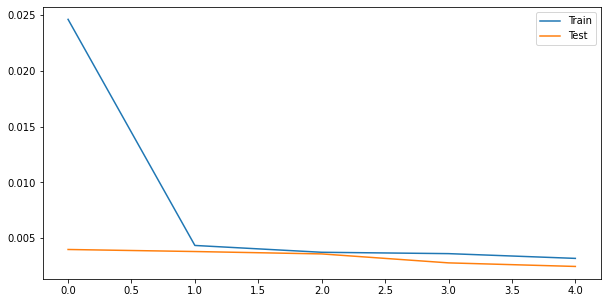

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

In [11]:
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

/Users/flq567/miniconda3/envs/alphapept/lib/python3.8/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-15 23:39:10.295425: W tensorflow/c/c_api.cc:291] Operation '{name:'dense/BiasAdd' id:1056 op device:{requested: '', assigned: ''} def:{{{node dense/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense/MatMul, dense/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


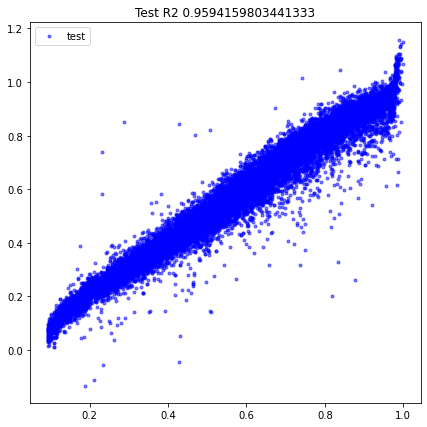

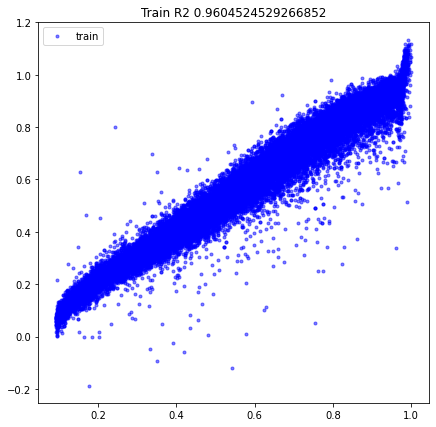

In [12]:
from sklearn.metrics import r2_score

plt.figure(figsize=(7,7))
plt.plot(y_test, y_hat_test, '.', color = 'b', label='test', alpha=0.5)
plt.title(f'Test R2 {r2_score(y_hat_test, y_test)}')
plt.legend()
plt.show()

plt.figure(figsize=(7,7))
plt.plot(y_train, y_hat_train, '.', color = 'b', label='train', alpha=0.5)
plt.title(f'Train R2 {r2_score(y_hat_train, y_train)}')
plt.legend()
plt.show()



In [13]:
df_all = df_org.copy()

In [14]:
peptides =df_all['sequence_naked'].tolist()
#charges = df['charge'].astype('uint32').tolist()

peps_embedded = np.zeros((len(peptides), max_len), dtype=np.int64)
int_array = np.array(peptides).view('uint32')
for idx, _ in enumerate(peptides):
    peps_embedded[idx, 0:len(_)] = np.array([_]).view('uint32')
    
x = peps_embedded

In [15]:
integer_encoded = lookup[x.flatten()].reshape(x.shape)

X = np.zeros((x.shape[0], x.shape[1], len(unique)))

XX, YY = np.meshgrid(np.arange(x.shape[1]), np.arange(x.shape[0]))

X[YY.flatten(), XX.flatten(), integer_encoded[YY.flatten(), XX.flatten()].astype('int')] = 1

In [16]:
x = model.predict(X).flatten()

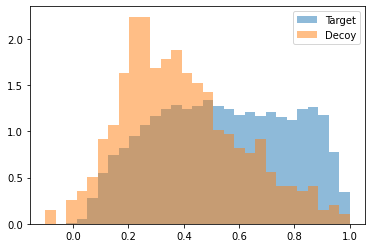

In [17]:
bins = np.linspace(-0.2,0.2,30)
bins = np.linspace(-0.1,1,30)

plt.hist(x[~df_all['decoy']], density=True, bins = bins, alpha=0.5, label='Target')
plt.hist(x[df_all['decoy']], density=True, bins = bins, alpha=0.5, label='Decoy')

plt.legend()
plt.show()

In [18]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")

INFO:root:test


In [19]:
ml = df_org.copy()
ml['rt_scaled'] = ml['rt'] / ml['rt'].max()
ml['delta'] = ml['rt_scaled'] - x

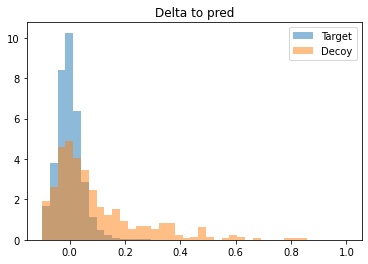

In [20]:
bins = np.linspace(-0.2,0.2,30)
bins = np.linspace(-0.1,1,40)

plt.hist(ml[~ml['decoy']]['delta'], density=True, bins = bins, alpha=0.5, label='Target')
plt.hist(ml[ml['decoy']]['delta'], density=True, bins = bins, alpha=0.5, label='Decoy')

plt.title('Delta to pred')
plt.legend()
plt.show()

## Re-scoring

In [21]:
df_all = ms_file.read(dataset_name='second_search')
df_all['sequence_naked'] = df_all['sequence'].apply(lambda x: ''.join([_ for _ in x if _.isupper()]))
df_all['decoy'] = df_all['sequence'].str.endswith('_decoy')

In [22]:
peptides =df_all['sequence_naked'].tolist()
#charges = df['charge'].astype('uint32').tolist()

peps_embedded = np.zeros((len(peptides), max_len), dtype=np.int64)
int_array = np.array(peptides).view('uint32')
for idx, _ in enumerate(peptides):
    peps_embedded[idx, 0:len(_)] = np.array([_]).view('uint32')
    
x = peps_embedded

integer_encoded = lookup[x.flatten()].reshape(x.shape)

X = np.zeros((x.shape[0], x.shape[1], len(unique)))

XX, YY = np.meshgrid(np.arange(x.shape[1]), np.arange(x.shape[0]))

X[YY.flatten(), XX.flatten(), integer_encoded[YY.flatten(), XX.flatten()].astype('int')] = 1

x = model.predict(X).flatten()

In [24]:
integer_encoded = lookup[x.flatten()].reshape(x.shape)

X = np.zeros((x.shape[0], x.shape[1], len(unique)))

XX, YY = np.meshgrid(np.arange(x.shape[1]), np.arange(x.shape[0]))

X[YY.flatten(), XX.flatten(), integer_encoded[YY.flatten(), XX.flatten()].astype('int')] = 1

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
x = model.predict(X).flatten()

In [ ]:
ml = df_all.copy()
ml['rt_scaled'] = ml['rt'] / ml['rt'].max()
ml['super_feature'] = ml['rt_scaled'] - x

In [ ]:
# Dummy score: Having decoy in there:

print('--- ML ---')

ml = get_ML_features(ml)

cv, features = train_RF(ml, plot=True)
ml = filter_with_ML(ml, cv, features = features)
ml = cut_global_fdr(ml, analyte_level='precursor',  plot=True)

In [ ]:
def embed_peps(peptides, max_len):

    #charges = df['charge'].astype('uint32').tolist()

    peps_embedded = np.zeros((len(peptides), max_len), dtype=np.int64)
    int_array = np.array(peptides).view('uint32')
    for idx, _ in enumerate(peptides):
        peps_embedded[idx, 0:len(_)] = np.array([_]).view('uint32')

    x = peps_embedded

    integer_encoded = lookup[x.flatten()].reshape(x.shape)

    X = np.zeros((x.shape[0], x.shape[1], len(unique)))

    XX, YY = np.meshgrid(np.arange(x.shape[1]), np.arange(x.shape[0]))

    X[YY.flatten(), XX.flatten(), integer_encoded[YY.flatten(), XX.flatten()].astype('int')] = 1
    
    return X

In [ ]:
model.predict(embed_peps(df_org['sequence_naked'].tolist(), max_len)).flatten()

## Decoy RT shift

In [ ]:
from alphapept.fasta import get_decoy_sequence

In [ ]:
df_org['decoy_sequence'] = df_org['sequence_naked'].apply(lambda x: get_decoy_sequence(x, pseudo_reverse=True))

In [ ]:
df_org[['sequence_naked', 'decoy_sequence']]

In [ ]:
df_org['rt_pred_target'] = model.predict(embed_peps(df_org['sequence_naked'].tolist(), max_len)).flatten()
df_org['rt_pred_decoy'] = model.predict(embed_peps(df_org['decoy_sequence'].tolist(), max_len)).flatten()

df_org['rt_pred_target_decoy_delta'] = df_org['rt_pred_target'] - df_org['rt_pred_decoy']

In [ ]:
df_org[['sequence_naked', 'decoy_sequence','rt_pred_target','rt_pred_decoy','rt_pred_target_decoy_delta']]

In [ ]:
(df_org['rt_pred_target_decoy_delta'] / df_org['rt_pred_target']).hist(bins = np.linspace(-1, 1 , 30))
plt.title('Relative delta from RT target to RT decoy (Rt_target-Rt_decoy)/Rt_target')
plt.show()

In [ ]:
df_org['rt_pred_target_decoy_delta'].hist(bins = np.linspace(-0.2, 0.2 , 30))
abs_mean = df_org['rt_pred_target_decoy_delta'].abs().mean()
plt.title(f'Absolute delta from RT target to RT decoy (Rt_target-Rt_decoy) abs_mean {abs_mean:.2f}')
plt.show()

In [ ]:
# Decoy Ruls with minimized shift?